## Importing Packages

In [1]:
import fastf1
import fastf1.plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fastf1.plotting.setup_mpl()

## Loading Session Data

In [2]:
year = 2020
race = "Belgian Grand Prix"

session = fastf1.get_session(year, race, 'R')
session.load()

req         WARNING 	DEFAULT CACHE ENABLED! (155.14 MB) C:\Users\odath\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '33'
core        WARNING 	Fixed incorrect tyre stint information for driver '23'
core        WARNING 	Fixed incorrect tyre stint information for driver '4'
core        WARNING 	Fixed incorrect tyre stint information for driver '7'
req            INFO 	Using cached data for car_data
req            IN

## Loading and Preparing Lap Data

In [3]:
laps = session.laps
laps = laps.sort_values(['Driver', 'LapNumber'])
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()
laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTimeSeconds
220,0 days 00:35:39.181000,ALB,23,0 days 00:01:57.297000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:52.414000,...,Red Bull Racing,0 days 00:33:41.719000,2020-08-30 13:13:41.783,1,6.0,False,,False,False,117.297
221,0 days 00:37:31.177000,ALB,23,0 days 00:01:51.996000,2.0,1.0,NaT,NaT,0 days 00:00:31.691000,0 days 00:00:50.494000,...,Red Bull Racing,0 days 00:35:39.181000,2020-08-30 13:15:39.245,1,6.0,False,,False,True,111.996
222,0 days 00:39:22.693000,ALB,23,0 days 00:01:51.516000,3.0,1.0,NaT,NaT,0 days 00:00:31.545000,0 days 00:00:50.127000,...,Red Bull Racing,0 days 00:37:31.177000,2020-08-30 13:17:31.241,1,6.0,False,,False,True,111.516
223,0 days 00:41:14.454000,ALB,23,0 days 00:01:51.761000,4.0,1.0,NaT,NaT,0 days 00:00:31.352000,0 days 00:00:50.608000,...,Red Bull Racing,0 days 00:39:22.693000,2020-08-30 13:19:22.757,1,6.0,False,,False,True,111.761
224,0 days 00:43:05.871000,ALB,23,0 days 00:01:51.417000,5.0,1.0,NaT,NaT,0 days 00:00:31.483000,0 days 00:00:50.122000,...,Red Bull Racing,0 days 00:41:14.454000,2020-08-30 13:21:14.518,1,6.0,False,,False,True,111.417


## Compound color map

In [4]:
COMPOUND_COLORS = {
    'SOFT': '#FF3333',
    'MEDIUM': '#FFD700',
    'HARD': "#C6BFBF",
    'INTERMEDIATE': '#39B54A',
    'WET': '#0077FF'
}

## Race Statergy Comparison between different drivers

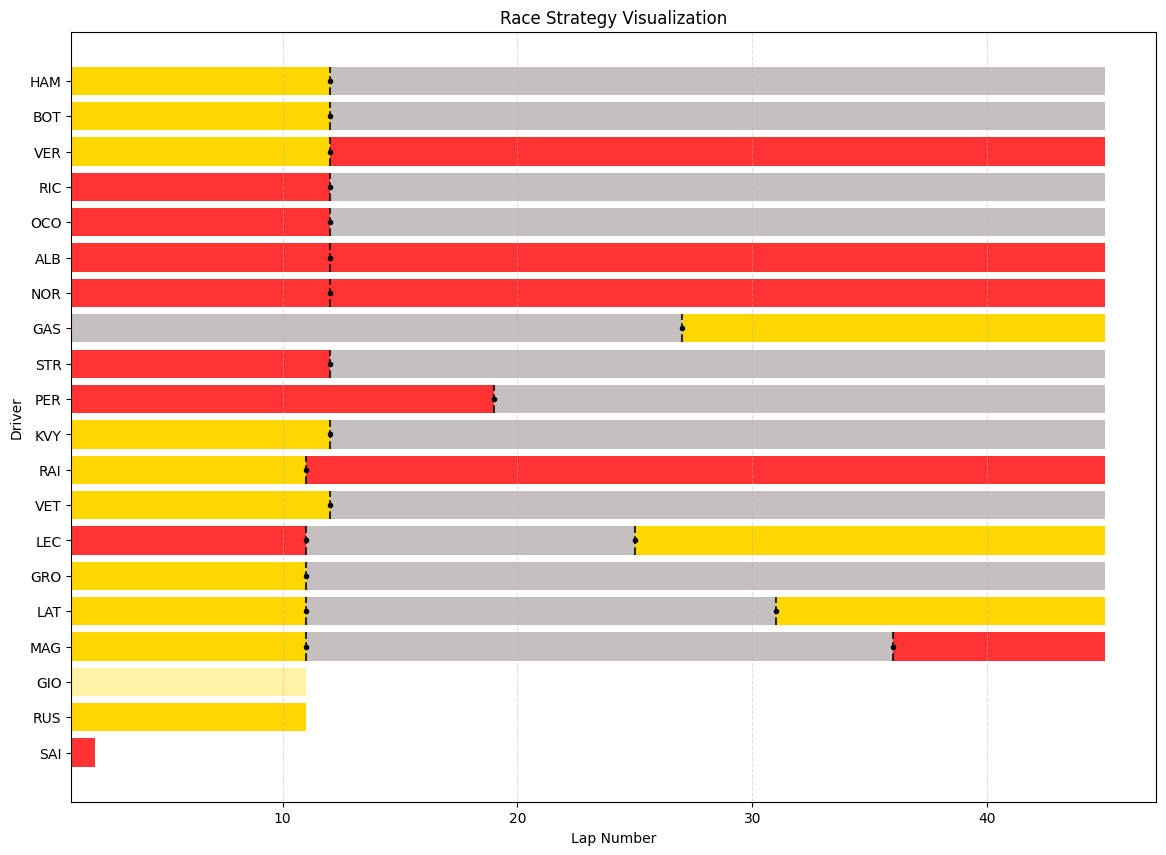

In [5]:
# Get finishing order
finishing_order = session.results.sort_values('Position')['Abbreviation'].tolist()
drivers = finishing_order[::-1]  # P1 at bottom

results = session.results
dnf_drivers = session.results[
    (session.results['Position'].isna()) |
    (session.results['Status'].str.contains('Accident|Engine|Retired|Gearbox', na=False))
]['Abbreviation'].tolist()


y_positions = {driver: i for i, driver in enumerate(drivers)}

fig, ax = plt.subplots(figsize=(14,10))

for driver in drivers:
    driver_laps = laps[laps['Driver'] == driver]
    stints = driver_laps.groupby('Stint')

    alpha = 0.35 if driver in dnf_drivers else 1.0
    y = y_positions[driver]

    for stint, data in stints:
        compound = data['Compound'].mode()[0]
        width = data['LapNumber'].max() - data['LapNumber'].min() + 1

        ax.barh(
            y,
            width,
            left=data['LapNumber'].min(),
            color=COMPOUND_COLORS.get(compound, '#AAAAAA'),
            alpha=alpha
        )

    # Pit stop markers
    pit_laps = driver_laps.loc[
        driver_laps['Stint'].diff() == 1, 'LapNumber'
    ]

    for lap in pit_laps:
        ax.plot(lap, y, marker='o', color='black', markersize=3, zorder=6)
        ax.vlines(
            lap,
            y - 0.4,
            y + 0.4,
            colors='black',
            linestyles='dashed',
            linewidth=1.5,
            alpha=0.8,
            zorder=5
        )

# Fix y-axis labels
ax.set_yticks(range(len(drivers)))
ax.set_yticklabels(drivers)

ax.set_xlabel("Lap Number")
ax.set_ylabel("Driver")
ax.set_title("Race Strategy Visualization")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()
